In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-transaction-data/bank.xlsx


In [2]:
# pip install kagglehub[pandas-datasets]
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = 'bank.xlsx'

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "apoorvwatsky/bank-transaction-data",
    file_path,
)

print("First 5 records:")
display(df.head())


/tmp/ipykernel_17/1607812101.py:9: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:


,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.
0,409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0,.
1,409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0,.
2,409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0,.
3,409000611074',2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,NaN,3000000.0,5500000.0,.
4,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6000000.0,.


In [3]:
def DataCleaning(df):

    # This is the copy of the data 
    processedData = df.copy()

    # Cleaning the data 
    print("Data Informations:\n",processedData.info())
    # Null values 
    print("\n\n\nDeposite null : ",processedData['DEPOSIT AMT'].isnull().sum()) 
    print("\nWithDrawal null :",processedData['WITHDRAWAL AMT'].isnull().sum())
    print("\nDATE null :",processedData['DATE'].isnull().sum())
    print("\nValue DATE null :",processedData['VALUE DATE'].isnull().sum())
    
    # Fill nulls (correct way)
    processedData['DEPOSIT AMT'] = processedData['DEPOSIT AMT'].fillna(0)
    processedData['WITHDRAWAL AMT'] = processedData['WITHDRAWAL AMT'].fillna(0)
    processedData['CHQ.NO.'] = processedData['CHQ.NO.'].fillna(0)
    
    # Feature Engineering
    processedData['ActualDay'] = processedData['VALUE DATE'].dt.day 
    processedData['ActualMonth'] = processedData['VALUE DATE'].dt.month
    processedData['ActualYear'] = processedData['VALUE DATE'].dt.year
    processedData = processedData.sort_values(by="VALUE DATE", ascending=False)

    # Droping unuseful data
    processedData = processedData.drop(columns=['Account No','.','VALUE DATE','CHQ.NO.'])
    
    # Data Discribtions
    print(processedData.columns)
    print("\nDataset Size",processedData.shape)

    display(processedData.head())

    
    return processedData
processData = DataCleaning(df)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116201 entries, 0 to 116200
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Account No           116201 non-null  object        
 1   DATE                 116201 non-null  datetime64[ns]
 2   TRANSACTION DETAILS  113702 non-null  object        
 3   CHQ.NO.              905 non-null     float64       
 4   VALUE DATE           116201 non-null  datetime64[ns]
 5   WITHDRAWAL AMT       53549 non-null   float64       
 6   DEPOSIT AMT          62652 non-null   float64       
 7   BALANCE AMT          116201 non-null  float64       
 8   .                    116201 non-null  object        
dtypes: datetime64[ns](2), float64(4), object(3)
memory usage: 8.0+ MB
Data Informations:
 None



Deposite null :  53549

WithDrawal null : 62652

DATE null : 0

Value DATE null : 0
Index(['DATE', 'TRANSACTION DETAILS', 'WITHDRAWAL AMT', 'DEPOSIT AMT'

,DATE,TRANSACTION DETAILS,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,ActualDay,ActualMonth,ActualYear
116200,2019-03-05,Sweep Trf To: 40900036427,5000.0,0.0,-1.901417e+09,5,3,2019
27037,2019-03-05,MICRO ATM WDL FEE DT04031,0.0,195800.0,-5.393314e+08,5,3,2019
86355,2019-03-05,FDRL/INTERNAL FUND TRANSFE,0.0,300000.0,-1.686924e+09,5,3,2019
86356,2019-03-05,FDRL/INTERNAL FUND TRANSFE,300000.0,0.0,-1.687224e+09,5,3,2019
86357,2019-03-05,FDRL/INTERNAL FUND TRANSFE,300000.0,0.0,-1.687524e+09,5,3,2019


In [4]:
def DataDiscribtion(df):
    total_day_counts = df['ActualDay'].value_counts()
    total_month_counts = df['ActualMonth'].value_counts()
    total_year_counts = df['ActualYear'].value_counts()

    # Over all discribtion
    display("Total list of days : ",total_day_counts.head())
    print("\n")
    display("Total list of months : ",total_month_counts.head())
    print("\n")
    display("Total list of year : ",total_year_counts.head())
    print("\n")
    # function wise distributions
    display(df.describe())

    # Less Then Zero balance
    count =0
    for value in df['BALANCE AMT']:
        if(value < 0):
            count = count +1;

    print("Minus Value in balance : ",count)
DataDiscribtion(processData)


'Total list of days : '

ActualDay
16    4806
27    4577
7     4517
9     4331
12    4279
Name: count, dtype: int64

'Total list of months : '

ActualMonth
7     11153
8     10832
9     10616
1     10510
12    10464
Name: count, dtype: int64

'Total list of year : '

ActualYear
2018    35534
2016    30373
2017    29112
2015    15658
2019     5524
Name: count, dtype: int64

,DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,ActualDay,ActualMonth,ActualYear
count,116201,1.162010e+05,1.162010e+05,1.162010e+05,116201.000000,116201.000000,116201.000000
mean,2017-05-20 00:08:40.477448448,2.068757e+06,2.052394e+06,-1.404852e+09,15.615907,6.680313,2016.869993
min,2015-01-01 00:00:00,0.000000e+00,0.000000e+00,-2.045201e+09,1.000000,1.000000,2015.000000
25%,2016-05-30 00:00:00,0.000000e+00,0.000000e+00,-1.690383e+09,8.000000,4.000000,2016.000000
50%,2017-06-05 00:00:00,0.000000e+00,5.000000e+03,-1.661395e+09,15.000000,7.000000,2017.000000
75%,2018-05-26 00:00:00,2.682500e+04,5.000000e+05,-1.236888e+09,23.000000,10.000000,2018.000000
max,2019-03-05 00:00:00,4.594475e+08,5.448000e+08,8.500000e+06,31.000000,12.000000,2019.000000
std,NaN,7.696881e+06,6.652164e+06,5.348202e+08,8.602524,3.491998,1.131124


Minus Value in balance :  113276


In [5]:
def DataPreProcess(df):
    processData = df.copy()
    processData['OverdraftAmount'] = (-processData['BALANCE AMT']).clip(lower=0)
    processData['ActualDate'] = pd.to_datetime(
        dict(
            year=processData['ActualYear'],
            month=processData['ActualMonth'],
            day=processData['ActualDay']
        )
    )
    dayAggData = (
        processData
        .groupby('ActualDate')[['BALANCE AMT',
                                'DEPOSIT AMT',
                                'WITHDRAWAL AMT',
                                'OverdraftAmount']]
        .sum()
        .sort_index()
    )
    monthAggData = (
        processData
        .groupby(['ActualYear','ActualMonth'])[['BALANCE AMT',
                                                'DEPOSIT AMT',
                                                'WITHDRAWAL AMT',
                                                'OverdraftAmount']]
        .sum()
    )
    monthAggData.index = pd.to_datetime(
        monthAggData.index.map(lambda x: f"{x[0]}-{x[1]}-01")
    )
    yearAggData = (
        processData
        .groupby('ActualYear')[['BALANCE AMT',
                                'DEPOSIT AMT',
                                'WITHDRAWAL AMT',
                                'OverdraftAmount']]
        .sum()
    )
    log_cols = ['DEPOSIT AMT', 'WITHDRAWAL AMT', 'OverdraftAmount']

    for col in log_cols:
        processData[col] = np.log1p(processData[col])
        dayAggData[col] = np.log1p(dayAggData[col])
        monthAggData[col] = np.log1p(monthAggData[col])
        yearAggData[col] = np.log1p(yearAggData[col])

    return processData, dayAggData, monthAggData, yearAggData
processData, dayAggData, monthAggData, yearAggData = DataPreProcess(processData)

display(processData.head())
display(dayAggData.head())
display(monthAggData.head())
display(yearAggData.head())


,DATE,TRANSACTION DETAILS,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,ActualDay,ActualMonth,ActualYear,OverdraftAmount,ActualDate
116200,2019-03-05,Sweep Trf To: 40900036427,8.517393,0.000000,-1.901417e+09,5,3,2019,21.365865,2019-03-05
27037,2019-03-05,MICRO ATM WDL FEE DT04031,0.000000,12.184854,-5.393314e+08,5,3,2019,20.105841,2019-03-05
86355,2019-03-05,FDRL/INTERNAL FUND TRANSFE,0.000000,12.611541,-1.686924e+09,5,3,2019,21.246173,2019-03-05
86356,2019-03-05,FDRL/INTERNAL FUND TRANSFE,12.611541,0.000000,-1.687224e+09,5,3,2019,21.246351,2019-03-05
86357,2019-03-05,FDRL/INTERNAL FUND TRANSFE,12.611541,0.000000,-1.687524e+09,5,3,2019,21.246528,2019-03-05


,BALANCE AMT,DEPOSIT AMT,WITHDRAWAL AMT,OverdraftAmount
ActualDate,,,,
2015-01-01,-3.710589e+09,14.511155,0.000000,22.034457
2015-01-02,-1.481999e+10,14.717954,15.520269,23.419243
2015-01-03,-6.353216e+09,14.896692,14.603968,22.572227
2015-01-05,-1.172347e+10,15.178798,14.988303,23.184858
2015-01-06,-9.530186e+09,15.110443,15.171360,22.977730


,BALANCE AMT,DEPOSIT AMT,WITHDRAWAL AMT,OverdraftAmount
2015-01-01,-3.101637e+11,18.571223,18.550123,26.460366
2015-02-01,-4.168798e+11,18.658697,18.647248,26.756064
2015-03-01,-3.772933e+11,18.502580,18.542858,26.656289
2015-04-01,-4.063980e+11,18.575013,18.570813,26.730599
2015-05-01,-5.997627e+11,18.898180,18.894510,27.119800


,BALANCE AMT,DEPOSIT AMT,WITHDRAWAL AMT,OverdraftAmount
ActualYear,,,,
2015,-2.394343e+13,24.671244,24.696116,30.806715
2016,-4.804100e+13,25.326214,25.329763,31.503094
2017,-4.206498e+13,24.769775,24.763659,31.370260
2018,-4.313675e+13,24.076642,24.096686,31.395432
2019,-6.059047e+12,20.805031,20.815207,29.432606


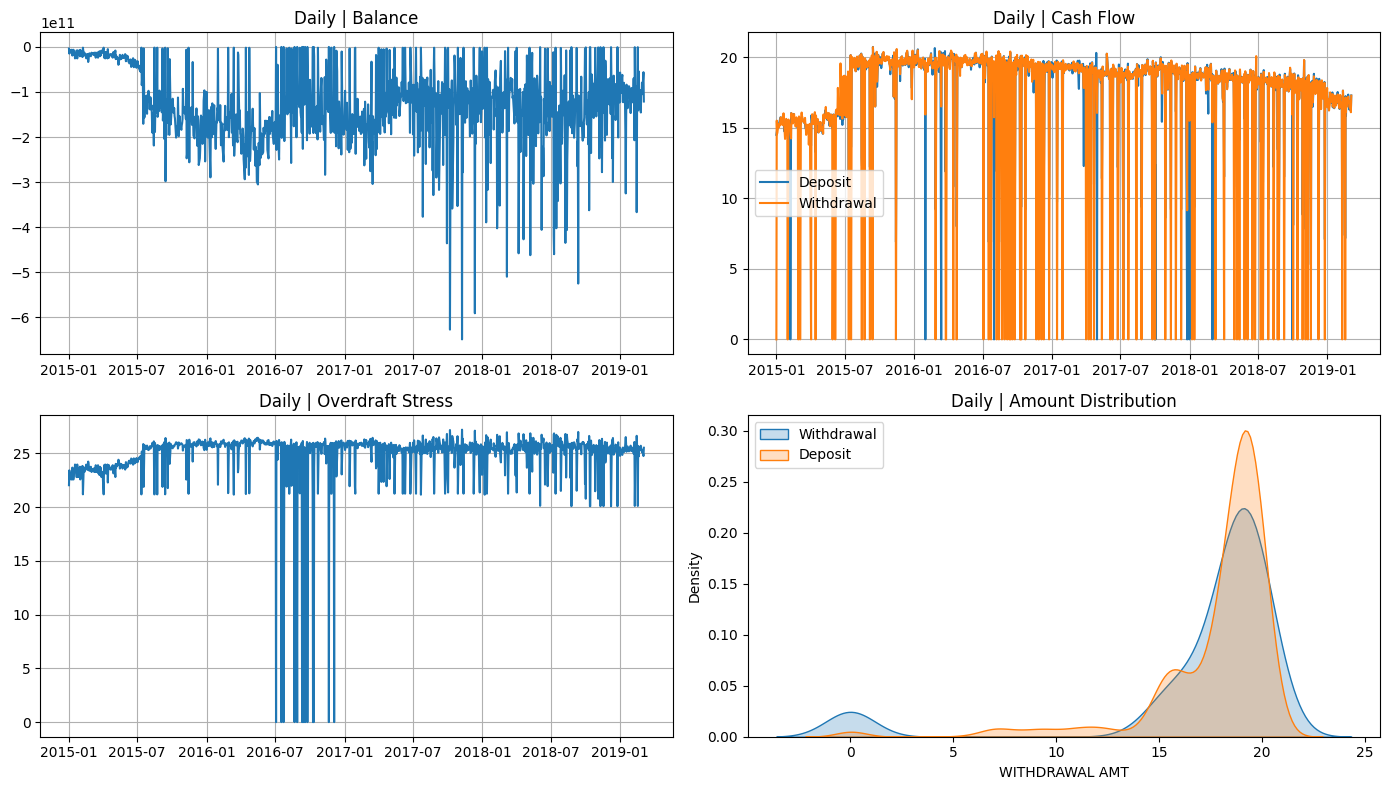

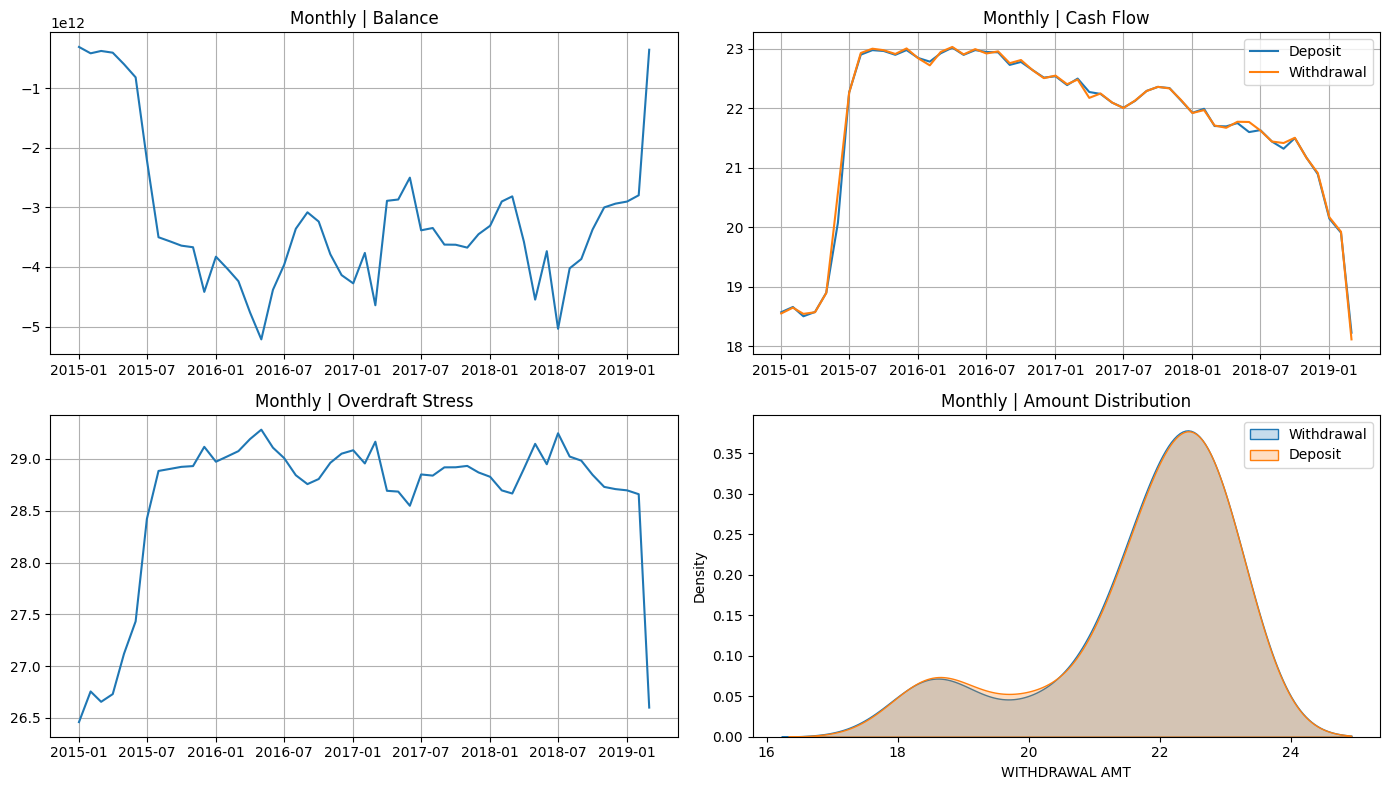

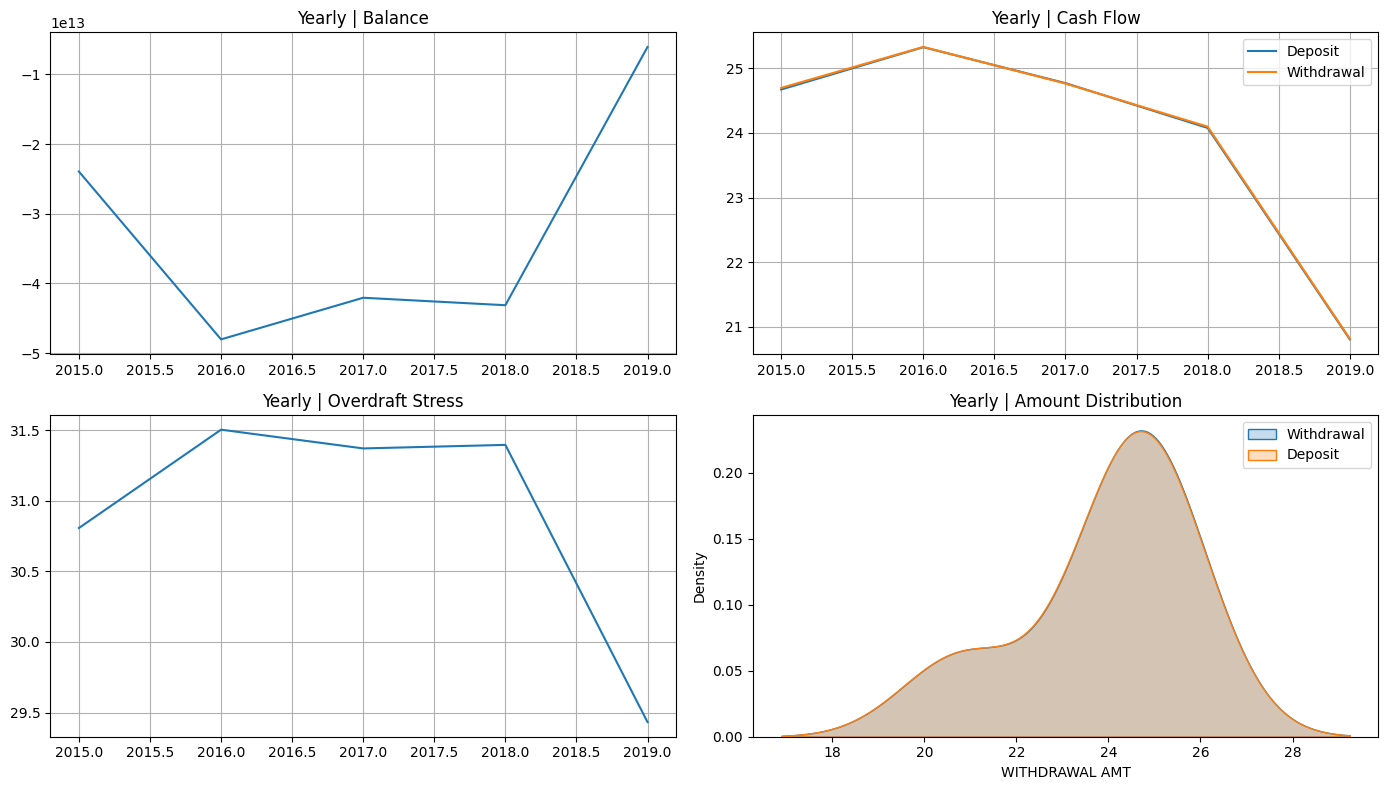

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualization(df, title_prefix='Time Series Analysis'):
    df = df.sort_index()

    plt.figure(figsize=(14, 8))

    # 1. Balance Trend
    plt.subplot(2, 2, 1)
    plt.plot(df.index, df['BALANCE AMT'])
    plt.title(f'{title_prefix} | Balance')
    plt.grid(True)

    # 2. Deposit vs Withdrawal
    plt.subplot(2, 2, 2)
    plt.plot(df.index, df['DEPOSIT AMT'], label='Deposit')
    plt.plot(df.index, df['WITHDRAWAL AMT'], label='Withdrawal')
    plt.legend()
    plt.title(f'{title_prefix} | Cash Flow')
    plt.grid(True)

    # 3. Overdraft Stress
    plt.subplot(2, 2, 3)
    plt.plot(df.index, df['OverdraftAmount'])
    plt.title(f'{title_prefix} | Overdraft Stress')
    plt.grid(True)

    # 4. Distribution Insight
    plt.subplot(2, 2, 4)
    sns.kdeplot(df['WITHDRAWAL AMT'], label='Withdrawal', fill=True)
    sns.kdeplot(df['DEPOSIT AMT'], label='Deposit', fill=True)
    plt.legend()
    plt.title(f'{title_prefix} | Amount Distribution')

    plt.tight_layout()
    plt.show()
visualization(dayAggData, 'Daily')
visualization(monthAggData, 'Monthly')
visualization(yearAggData, 'Yearly')
